<font size=7> __Data Analysis for Individual Dwell__<font>


# __Libraries__

In [ ]:
%%capture
pip install folium

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial import distance

# __Data Preparation__

## __Load Data__

In [ ]:
url = "https://gps-london.s3.eu-west-2.amazonaws.com/gps.csv"
df = pd.read_csv(url)

df.head()

,user_id,datetime,lat,lon
0,00F70625-4B30-4B4F-A0E3-A5CD9474E34F,2018-01-09 08:49:29+00:00,51.504017,-0.086455
1,00F70625-4B30-4B4F-A0E3-A5CD9474E34F,2018-01-09 08:52:01+00:00,51.505192,-0.090741
2,00F70625-4B30-4B4F-A0E3-A5CD9474E34F,2018-01-09 08:52:32+00:00,51.504098,-0.095321
3,00F70625-4B30-4B4F-A0E3-A5CD9474E34F,2018-01-09 08:55:55+00:00,51.504084,-0.109144
4,00F70625-4B30-4B4F-A0E3-A5CD9474E34F,2018-01-09 08:58:01+00:00,51.504191,-0.113367


## __Exploratory Data Analysis__

In [ ]:
# Measurement scale type of attributes
print(df.dtypes)

user_id      object
datetime     object
lat         float64
lon         float64
dtype: object


In [ ]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
user_id     0
datetime    0
lat         0
lon         0
dtype: int64


### __Datetime__

In [ ]:
# Converting 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Verify the conversion
print(df['datetime'].dtype)

datetime64[ns, UTC]


In [ ]:
# Datetime exploration: range
df['datetime'].agg(['min', 'max'])

min   2018-01-08 00:00:20+00:00
max   2018-01-19 23:59:41+00:00
Name: datetime, dtype: datetime64[ns, UTC]

In [ ]:
# Datetime exploration: days of week
df['datetime'].dt.day_name().value_counts()

Thursday     374148
Wednesday    368796
Tuesday      360226
Friday       350923
Monday       315918
Name: datetime, dtype: int64

In [ ]:
# Datetime exploration: days of month
df['datetime'].dt.day.value_counts().sort_index()

8     151019
9     178371
10    185832
11    189839
12    176933
15    164899
16    181855
17    182964
18    184309
19    173990
Name: datetime, dtype: int64

In [ ]:
# Datetime exploration: hours of day
df['datetime'].dt.hour.value_counts().sort_index()

0      17690
1      10135
2       7361
3       6328
4      10159
5      16443
6      47600
7     114202
8     206913
9     133279
10     65445
11     57343
12     65607
13     72383
14     64546
15     75257
16    110188
17    185939
18    190295
19    110019
20     69892
21     52946
22     47892
23     32149
Name: datetime, dtype: int64

### __Users__

In [ ]:
# Analysis of Data Recorded per User
users = df.user_id.value_counts().rename_axis("unique_ids").reset_index(name="counts")
print("Number of Individual Users : ", len(users),
      "\nMaximum Observation per User : ", users.counts.max(),
      "\nMinimum Observation per User :", users.counts.min())

Number of Individual Users :  31606 
Maximum Observation per User :  3430 
Minimum Observation per User : 20


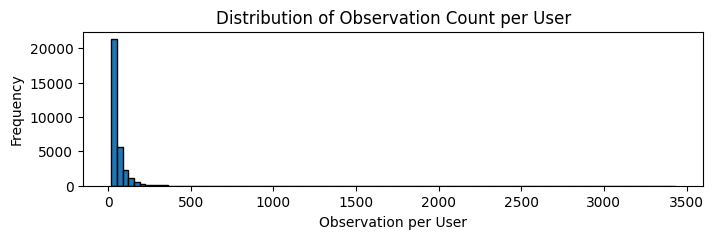

In [ ]:
# Distribution of Recordeds per User
plt.rcParams["figure.figsize"] = (8,2)
users.hist(column="counts", bins= 100, edgecolor='black', grid=False)
plt.xlabel('Observation per User')
plt.ylabel('Frequency')
plt.title("Distribution of Observation Count per User");

### __Coordinates__

In [ ]:
# Basic statistical description of attributes
df.describe()

,lat,lon
count,1.770011e+06,1.770011e+06
mean,5.149896e+01,-9.836186e-02
std,6.002999e-03,1.186196e-02
min,5.148249e+01,-1.213403e-01
25%,5.149463e+01,-1.088844e-01
50%,5.150077e+01,-9.862888e-02
75%,5.150407e+01,-8.793030e-02
max,5.150664e+01,-7.640790e-02


In [ ]:
# Calculate mean distance between consecutive points for each user
user_average_distances = []
for user_id, user_data in df.groupby('user_id'):
    coords = user_data[['lat', 'lon']]
    pairwise_distances = distance.cdist(coords, coords, 'euclidean')
    consecutive_distances = [pairwise_distances[i, i+1] for i in range(len(pairwise_distances)-1)]
    average_distance = sum(consecutive_distances) / len(consecutive_distances)
    user_average_distances.append((user_id, average_distance))

# Compute mean distance for all users
mean_distance = sum(avg_dist for _, avg_dist in user_average_distances) / len(user_average_distances)
print("Mean Distance: ", mean_distance)


Mean Distance:  0.004458750501176313


In [ ]:
# Analysis of user average movement
user_avg_dist = pd.DataFrame(user_average_distances)
user_avg_dist.columns=["user_id", "dist"]
user_avg_dist.sort_values(by="dist").head(10)

,user_id,dist
7845,3fd67b77-ac51-431b-a023-6d11b0a6f692,0.000000e+00
30322,d49b234b-c313-4343-8069-de7df47e32b4,0.000000e+00
9785,4e1248e4-21ae-4b4c-a924-d18a04a69ecb,0.000000e+00
30422,d8253dd3-7794-42f2-ac53-192d0b713e95,0.000000e+00
10222,533b0ba4-1e50-4a8f-9c2d-5035fbcfd0a3,9.774985e-07
14669,775670d8-aeca-4a26-b93e-d4d8c7b47204,1.077956e-06
4841,27933744-A9F4-4260-8D14-6090C176B5B4,2.480883e-06
12584,65e95f08-7999-4c2f-86d1-6c16aa1404af,4.362538e-06
3752,1bd4bd8d-43ff-4298-8bb2-72f065fc6e76,4.825436e-06
31190,f162daf1-64d7-4cce-88da-b8c982a6dcc6,4.871889e-06


min    0.000000
max    0.018883
Name: dist, dtype: float64

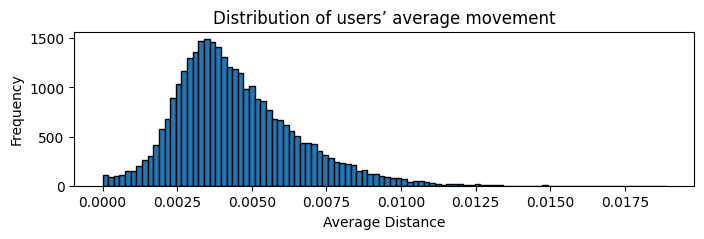

In [ ]:
user_avg_dist.hist(column = "dist", bins = 100, edgecolor='black', grid=False)
plt.xlabel('Average Distance')
plt.ylabel('Frequency')
plt.title('Distribution of users’ average movement')
user_avg_dist.dist.agg(['min', 'max'])

In [ ]:
# Function to visualise users' movement
def user_plots(selected_user, plt_title):
    plt.title(plt_title)
    plt.plot(selected_user["datetime"], selected_user["lat"])
    plt.ylabel("Latitude")
    plt.show()
    plt.plot(selected_user["datetime"], selected_user["lon"])
    plt.ylabel("Longitude")
    plt.show()
    plt.scatter(selected_user.lat, selected_user.lon, alpha=0.5)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")

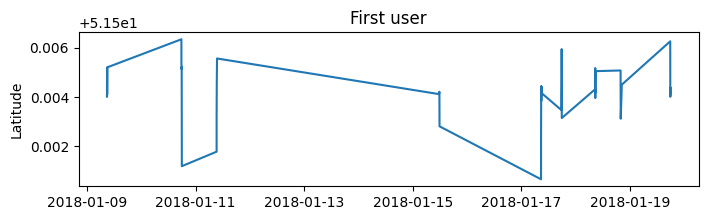

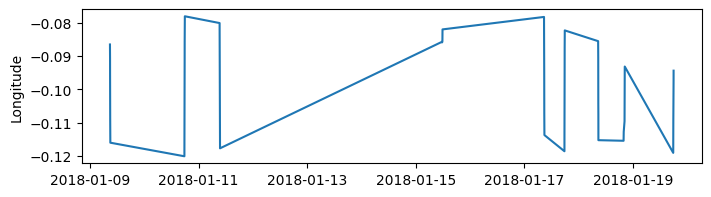

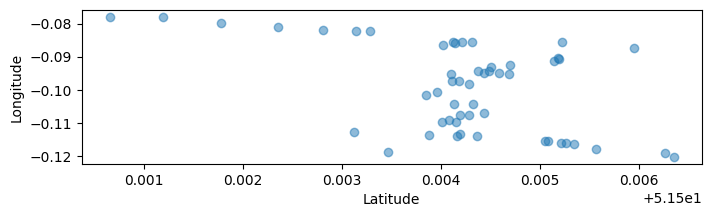

In [ ]:
# user_1
user_1 = df[df.user_id==df.iloc[0]["user_id"]]
user_plots(user_1, "First user")

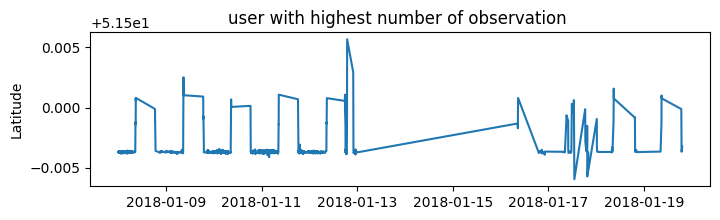

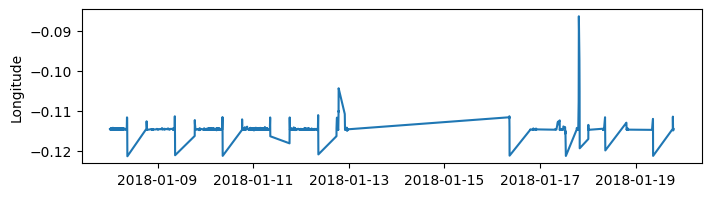

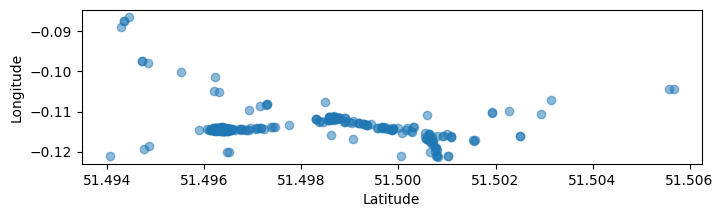

In [ ]:
#user with highest number of observation
user_max = df[df.user_id==users.iloc[0]["unique_ids"]]
user_plots(user_max, "user with highest number of observation")

# Algorithm to Estimate Individual Dwells

##  Clustering

In [ ]:
kms_per_radian = 6371.0088
eps= mean_distance/kms_per_radian  # (maximum distance between two samples for them to be considered as in the same neighborhood)
min_samples = 4
min_duration_minutes = 15 # minimum duration of dwell in minutes

# Initialize lists to store dwell information for all individuals
all_dwells = []
# Iterate through each individual
for user_id, user_data in df.groupby('user_id'):
    # Convert latitude and longitude from degrees to radians
    user_data['lat_rad'] = np.radians(user_data['lat'])
    user_data['lon_rad'] = np.radians(user_data['lon'])

    # Initialize DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')

    # Fit the clustering algorithm and assign clusters to data points
    user_data['cluster'] = dbscan.fit_predict(user_data[['lat_rad', 'lon_rad']])

    # Extract individual dwells from clusters
    for cluster_id in user_data['cluster'].unique():
        if cluster_id == -1:  # Noise points (not part of any cluster)
            continue
        cluster_points = user_data[user_data['cluster'] == cluster_id]
        start_time = cluster_points['datetime'].min()
        end_time = cluster_points['datetime'].max()
        dwell_duration_minutes = (end_time - start_time).total_seconds() / 60
        if dwell_duration_minutes >= min_duration_minutes:
            start_lat = cluster_points.iloc[0]['lat']
            start_lon = cluster_points.iloc[0]['lon']
            end_lat = cluster_points.iloc[-1]['lat']
            end_lon = cluster_points.iloc[-1]['lon']
            dwell = {'user_id': user_id, 'start_time': start_time, 'end_time': end_time,
                     'start_lat': start_lat, 'start_lon': start_lon, 'end_lat': end_lat, 'end_lon': end_lon}
            all_dwells.append(dwell)

# Convert dwell information to DataFrame
all_dwells_df = pd.DataFrame(all_dwells)

# Print number of dwell instances across all individuals
print("Number of dwell instances:", len(all_dwells_df))

Number of dwell instances: 12475


In [ ]:
# Find the number of unique user IDs related to dwell instances
unique_user_ids = all_dwells_df['user_id'].nunique()
print("Number of unique user IDs related to dwell instances:", unique_user_ids)

Number of unique user IDs related to dwell instances: 7303


## Visualisation

In [ ]:
# Create a map centered around the mean latitude and longitude of all dwellings
map_center = [all_dwells_df['start_lat'].mean(), all_dwells_df['start_lon'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Add markers for each dwelling
for index, row in all_dwells_df.iterrows():
    popup_text = f"User ID: {row['user_id']}<br>Start Time: {row['start_time']}<br>End Time: {row['end_time']}"
    folium.Marker(location=[row['start_lat'], row['start_lon']], popup=popup_text).add_to(mymap)

# Save the map to an HTML file
mymap.save('dwellings_map.html')


In [ ]:
mymap